In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("SpaceInvadersNoFrameskip-v4")
    env = PreprocessAtari(env, height=84, width=84,
                          crop = lambda img: img,
                          color=False, n_frames=4,
                          reward_scale = 0.2)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (4, 84, 84)
Num actions: 6
Action names: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


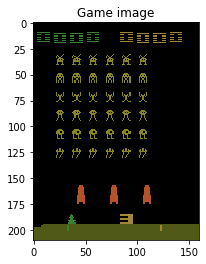

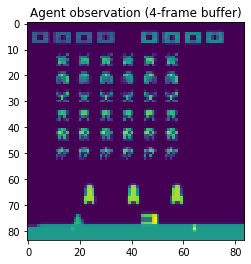

In [2]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s[0])#.transpose([0,1,2]).reshape([42,-1]))
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    
    def __init__(self, shape_in, action_shape):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(shape_in, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.dense1 = nn.Linear(64*7*7, 512)
        self.dense2 = nn.Linear(512, action_shape)
        self.dense3 = nn.Linear(512, 1)
        
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.dense1(x))
        logits = self.dense2(x)
        values = self.dense3(x)
        return logits, values[:, 0]
    
    def sample_actions(self, agent_outputs):
        logits, state_values = agent_outputs
        logits = logits.cpu().detach().numpy()
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [4]:
obs_shape, n_actions

((4, 84, 84), 6)

In [5]:
device = torch.device('cuda')

In [6]:
agent = Network(obs_shape[0], n_actions).to(device)

In [7]:
state = [env.reset()]
state = torch.tensor(state, device=device)
logits, value = agent(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[ 0.0458,  0.0363, -0.0078,  0.0195, -0.0340, -0.0293]],
       device='cuda:0', grad_fn=<AddmmBackward>)
state values:
 tensor([-0.0272], device='cuda:0', grad_fn=<SelectBackward>)


In [8]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """
    agent.train(False)
    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            state = torch.tensor([state], device=device)
            action = agent.sample_actions(agent(state))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    agent.train(True)
    return game_rewards

In [9]:
env_monitor = gym.wrappers.Monitor(env, directory="space_invaders_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print(rw)

[15.0, 36.0, 24.0]


In [10]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./space_invaders_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./space_invaders_videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [11]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [12]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_states = torch.tensor(batch_states, device=device)
batch_actions = agent.sample_actions(agent.forward(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])

State shape: torch.Size([10, 4, 84, 84])
Actions: [2 5 4]
Rewards: [0. 0. 0.]
Done: [False False False]


## Actor Critic

In [13]:
from IPython.display import clear_output
from tqdm import trange
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

In [14]:
gamma = 0.99
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

def compute_loss(dictionary):
    logits, state_values = agent.forward(dictionary['states_ph'])
    next_logits, next_state_values = agent.forward(dictionary['next_states_ph'])
    next_state_values = next_state_values * torch.tensor(1 - dictionary['is_done_ph'], device=device)
    probs = F.softmax(logits, -1)
    logprobs = F.log_softmax(logits, -1)
    logp_actions = torch.sum(logprobs * F.one_hot(torch.tensor(dictionary['actions_ph'], device=device),
                                                  n_actions), axis=-1)
    advantage = torch.tensor(dictionary['rewards_ph'], device=device) + gamma * (next_state_values - state_values)
    print(advantage.shape)
    entropy =  - torch.sum(probs * logprobs, 1)
    actor_loss =  - torch.mean(logp_actions * advantage.detach()) - 0.001 * torch.mean(entropy)
    target_state_values = torch.tensor(dictionary['rewards_ph'], device=device) + gamma*next_state_values
    critic_loss = torch.mean((state_values - target_state_values.detach())**2 )
    return actor_loss + critic_loss, entropy.cpu().detach().numpy()

In [15]:
for i in trange(1000000): 
    batch_states = torch.tensor(batch_states, device=device)
    batch_actions = agent.sample_actions(agent.forward(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        'states_ph': batch_states,
        'actions_ph': batch_actions,
        'next_states_ph': torch.tensor(batch_next_states, device=device),
        'rewards_ph': batch_rewards,
        'is_done_ph': batch_done,
    }
    batch_states = batch_next_states
    
    loss_, ent_t = compute_loss(feed_dict)
    entropy_history.append(np.mean(ent_t))
    
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")

        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
#         plt.plot(numpy_ewma_vectorized_v2(np.array(rewards_history), 10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
#         plt.plot(numpy_ewma_vectorized_v2(np.array(entropy_history), 1000), marker='.', label='rewards ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()

  0%|          | 0/1000000 [00:00<?, ?it/s]

torch.Size([10])


## Final evaluation

In [ ]:
env_monitor = gym.wrappers.Monitor(env, directory="space_invaders_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./space_invaders_videos/")))

In [ ]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./space_invaders_videos/"+video_names[-1])) 

In [ ]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./space_invaders_videos/"+video_names[-1])) 